In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings("ignore")

In [4]:
RAND_VAL=42
num_folds=5 ## Number of folds
n_est=1500 

In [5]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [6]:
df_train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [8]:
scale_cols = ['Age','CreditScore', 'Balance', 'Tenure', 'NumOfProducts', 'EstimatedSalary']
###
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

In [9]:
vectorizer = TfidfVectorizer(max_features=1000)
vectors_train = vectorizer.fit_transform(df_train['Surname'])
vectors_test = vectorizer.transform(df_test['Surname'])
#
svd = TruncatedSVD(3)
x_pca_train = svd.fit_transform(vectors_train)
x_pca_test = svd.transform(vectors_test)

# Convert to DataFrames
tfidf_df_train = pd.DataFrame(x_pca_train)
tfidf_df_test = pd.DataFrame(x_pca_test)

# Naming columns in the new DataFrames
cols = [('Surname' + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
tfidf_df_train.columns = cols
tfidf_df_test.columns = cols
    
# Reset the index of the DataFrames before concatenation
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Concatenate transformed features with original data
df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
df_test = pd.concat([df_test, tfidf_df_test], axis="columns")

In [10]:
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['len_SurName'] = df_train['Surname'].apply(lambda x: len(x))
    
    cat_cols = ['Geography', 'Gender']
    df=pd.get_dummies(df,columns=cat_cols)
    return df

In [11]:
df_train = getFeats(df_train)
df_test = getFeats(df_test)
df_train.head()

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,...,Surname_tfidf_2,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure,len_SurName,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,...,-1.180880e-06,0,0.0,1.5,14,True,False,False,False,True
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,...,-6.300033e-07,0,1.0,0.5,13,True,False,False,False,True
2,2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,...,8.410237e-03,0,0.0,5.0,5,True,False,False,False,True
3,3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,...,5.164943e-03,0,1.0,2.0,3,True,False,False,False,True
4,4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,...,-4.561514e-07,0,1.0,2.5,9,False,False,True,False,True


In [12]:
feat_cols=df_train.columns.drop(['id', 'CustomerId', 'Surname','Exited'])
feat_cols=feat_cols.drop(scale_cols)
feat_cols

Index(['HasCrCard', 'IsActiveMember', 'Age_scaled', 'CreditScore_scaled',
       'Balance_scaled', 'Tenure_scaled', 'NumOfProducts_scaled',
       'EstimatedSalary_scaled', 'Surname_tfidf_0', 'Surname_tfidf_1',
       'Surname_tfidf_2', 'IsSenior', 'IsActive_by_CreditCard',
       'Products_Per_Tenure', 'len_SurName', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [13]:
X=df_train[feat_cols]
y=df_train['Exited']

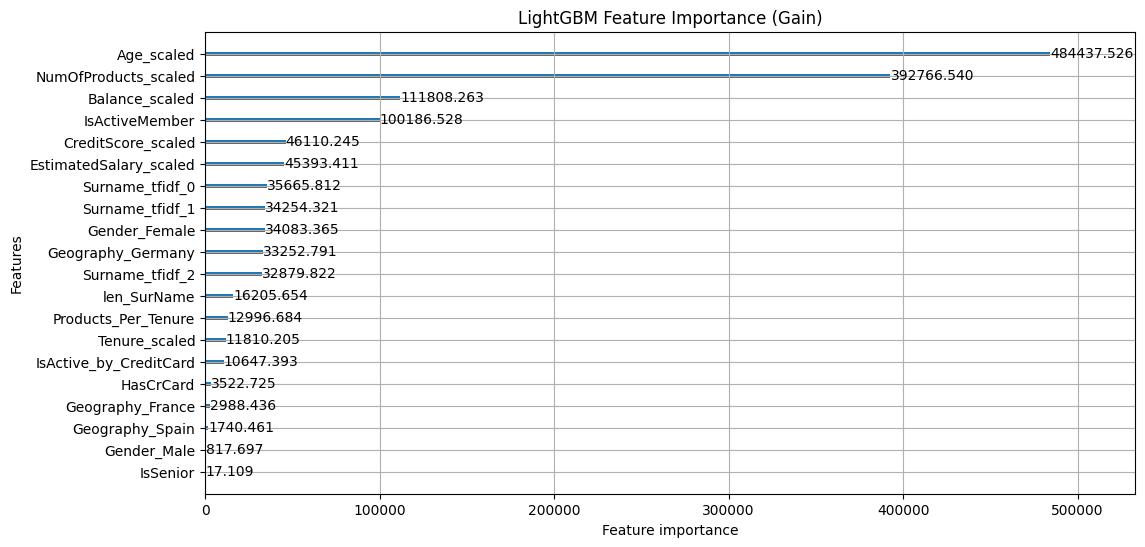

In [14]:
LGB=lgb.LGBMClassifier(learning_rate=0.03,n_estimators=n_est,random_state=RAND_VAL,
                      max_depth=10,num_leaves=40)
LGB.fit(X,y)
lgb.plot_importance(LGB, importance_type="gain", figsize=(12,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [15]:
folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    LGB=lgb.LGBMClassifier(learning_rate=0.03,n_estimators=n_est,random_state=RAND_VAL,
                          max_depth=10,num_leaves=40)
    LGB.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        early_stopping_rounds=100,verbose=100)
    
    y_pred_val = LGB.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = LGB.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

[100]	valid_0's auc: 0.889319	valid_0's binary_logloss: 0.32335
[200]	valid_0's auc: 0.891508	valid_0's binary_logloss: 0.317872
[300]	valid_0's auc: 0.892463	valid_0's binary_logloss: 0.316201
[400]	valid_0's auc: 0.892715	valid_0's binary_logloss: 0.315701
[500]	valid_0's auc: 0.892734	valid_0's binary_logloss: 0.315541
AUC for fold  0 :  0.8927737959270236
----------------
[100]	valid_0's auc: 0.888865	valid_0's binary_logloss: 0.323044
[200]	valid_0's auc: 0.89153	valid_0's binary_logloss: 0.317434
[300]	valid_0's auc: 0.892803	valid_0's binary_logloss: 0.315619
[400]	valid_0's auc: 0.893485	valid_0's binary_logloss: 0.314691
[500]	valid_0's auc: 0.89371	valid_0's binary_logloss: 0.314372
[600]	valid_0's auc: 0.89379	valid_0's binary_logloss: 0.314225
[700]	valid_0's auc: 0.893819	valid_0's binary_logloss: 0.314189
[800]	valid_0's auc: 0.89389	valid_0's binary_logloss: 0.314115
[900]	valid_0's auc: 0.893891	valid_0's binary_logloss: 0.314145
AUC for fold  1 :  0.8939502323237806
--

In [16]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.8936281804374495)

In [17]:
y_pred = test_preds.mean(axis=0)
df_sub = df_test[['id']]
df_sub['Exited'] = y_pred
df_sub.head()

,id,Exited
0,165034,0.010286
1,165035,0.722566
2,165036,0.037199
3,165037,0.203467
4,165038,0.360740


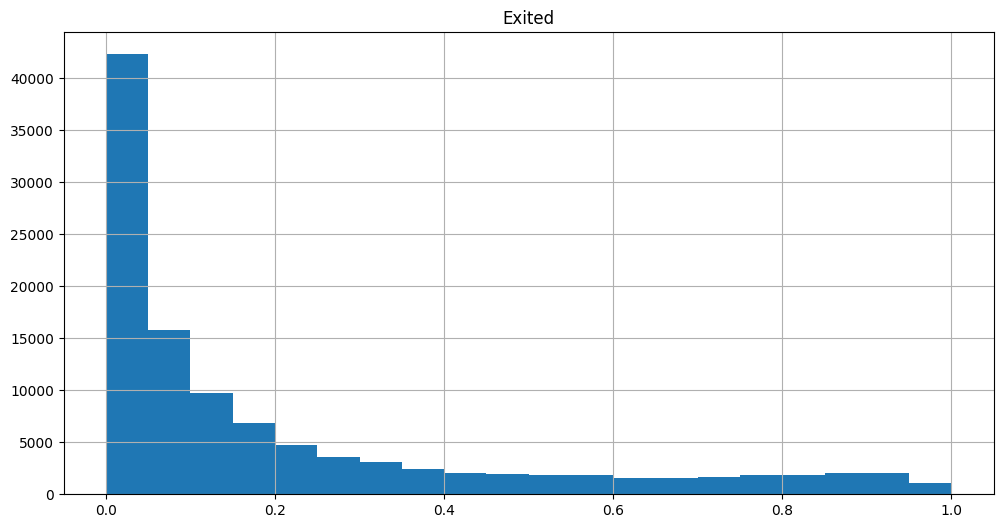

In [18]:
df_sub.to_csv("submission.csv",index=False)
df_sub.hist(column='Exited', bins=20, range=[0,1],figsize=(12,6))
plt.show()